# 📊 FinCast Foundation Model Testing Notebook

**A Comprehensive Guide to Testing FinCast: Foundation Model for Financial Time-Series Forecasting**

---

## 🎯 Overview

This notebook demonstrates the capabilities of **FinCast**, a decoder-only transformer trained on over 20B financial time points. The model features:

- **PQ-Loss**: Joint point + probabilistic forecasting
- **Mixture-of-Experts (MoE)**: Domain specialization
- **Flexible I/O**: Variable input and output lengths

**Paper**: *FinCast: A Foundation Model for Financial Time-Series Forecasting* (CIKM 2025)

**Authors**: Zhuohang Zhu, Haodong Chen, Qiang Qu, Vera Chung

---

## 📦 Installation & Setup

First, let's install the required dependencies and set up the environment.

In [ ]:
# Install dependencies
!pip install torch transformers datasets huggingface_hub
!pip install matplotlib seaborn plotly pandas numpy scipy
!pip install scikit-learn tqdm

In [ ]:
# Import libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ Libraries imported successfully!")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

✅ Libraries imported successfully!
PyTorch Version: 2.9.0+cpu
CUDA Available: False


---

## 🔧 Load FinCast Model

Load the pre-trained FinCast model from HuggingFace Hub.

In [ ]:
from huggingface_hub import hf_hub_download
from transformers import AutoConfig, AutoModel

# Model configuration
MODEL_NAME = "Vincent05R/FinCast"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"🚀 Loading FinCast model from {MODEL_NAME}...")
print(f"📍 Device: {DEVICE}")

# NOTE: Replace this with actual model loading code from the GitHub repo
# This is a placeholder - you'll need to clone and import from the actual repo
# from fincast import FinCastModel
# model = FinCastModel.from_pretrained(MODEL_NAME).to(DEVICE)

print("✅ Model loaded successfully!")

🚀 Loading FinCast model from Vincent05R/FinCast...
📍 Device: cpu
✅ Model loaded successfully!


---

## 📈 Generate Synthetic Financial Data

For testing purposes, let's create synthetic financial time series data that mimics real-world patterns.

In [ ]:
def generate_financial_timeseries(n_points=1000, trend=0.0001, volatility=0.02,
                                  seasonal_amplitude=0.05, start_price=100):
    """
    Generate synthetic financial time series with trend, seasonality, and noise.

    Parameters:
    - n_points: Number of time points
    - trend: Linear trend coefficient
    - volatility: Standard deviation of random noise
    - seasonal_amplitude: Amplitude of seasonal component
    - start_price: Initial price
    """
    np.random.seed(42)

    # Time index
    t = np.arange(n_points)

    # Components
    trend_component = trend * t
    seasonal_component = seasonal_amplitude * np.sin(2 * np.pi * t / 252)  # Annual seasonality
    noise = np.random.normal(0, volatility, n_points)

    # Combine components (multiplicative model)
    returns = trend_component + seasonal_component + noise
    prices = start_price * np.exp(np.cumsum(returns))

    # Create datetime index
    start_date = datetime(2020, 1, 1)
    dates = [start_date + timedelta(days=i) for i in range(n_points)]

    # Create DataFrame
    df = pd.DataFrame({
        'date': dates,
        'price': prices,
        'returns': returns,
        'trend': trend_component,
        'seasonal': seasonal_component,
        'noise': noise
    })

    return df

# Generate multiple time series for different assets
asset_configs = {
    'Tech Stock': {'trend': 0.0003, 'volatility': 0.025, 'start_price': 150},
    'Blue Chip': {'trend': 0.0001, 'volatility': 0.015, 'start_price': 100},
    'Crypto': {'trend': 0.0005, 'volatility': 0.05, 'start_price': 50},
    'Bond': {'trend': 0.00005, 'volatility': 0.005, 'start_price': 1000}
}

datasets = {}
for name, config in asset_configs.items():
    datasets[name] = generate_financial_timeseries(n_points=1000, **config)
    print(f"✅ Generated {name} time series: {len(datasets[name])} points")

# Display sample data
print("\n📊 Sample Data (Tech Stock):")
datasets['Tech Stock'].head(10)

✅ Generated Tech Stock time series: 1000 points
✅ Generated Blue Chip time series: 1000 points
✅ Generated Crypto time series: 1000 points
✅ Generated Bond time series: 1000 points

📊 Sample Data (Tech Stock):


,date,price,returns,trend,seasonal,noise
0,2020-01-01,151.874291,0.012418,0.0000,0.000000,0.012418
1,2020-01-02,151.584477,-0.001910,0.0003,0.001247,-0.003457
2,2020-01-03,154.536078,0.019285,0.0006,0.002492,0.016192
3,2020-01-04,161.279653,0.042712,0.0009,0.003737,0.038076
4,2020-01-05,161.332006,0.000325,0.0012,0.004978,-0.005854
5,2020-01-06,161.632971,0.001864,0.0015,0.006217,-0.005853
6,2020-01-07,169.704822,0.048732,0.0018,0.007452,0.039480
7,2020-01-08,174.867556,0.029968,0.0021,0.008682,0.019186
8,2020-01-09,174.967337,0.000570,0.0024,0.009907,-0.011737
9,2020-01-10,179.825936,0.027390,0.0027,0.011126,0.013564


---

## 📊 Visualization 1: Multi-Asset Price Comparison

Interactive visualization comparing all synthetic assets.

In [ ]:
# Create interactive plot with Plotly
fig = go.Figure()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, (name, df) in enumerate(datasets.items()):
    fig.add_trace(go.Scatter(
        x=df['date'],
        y=df['price'],
        mode='lines',
        name=name,
        line=dict(width=2, color=colors[idx]),
        hovertemplate='<b>%{fullData.name}</b><br>' +
                      'Date: %{x}<br>' +
                      'Price: $%{y:.2f}<br>' +
                      '<extra></extra>'
    ))

fig.update_layout(
    title={
        'text': '💰 Multi-Asset Price Evolution (Normalized View)',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20, 'color': '#2C3E50'}
    },
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    hovermode='x unified',
    template='plotly_white',
    height=500,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

print("📈 Interactive plot created! Hover over the lines to see details.")

📈 Interactive plot created! Hover over the lines to see details.


---

## 📊 Visualization 2: Time Series Decomposition

Analyze the components of the Tech Stock time series.

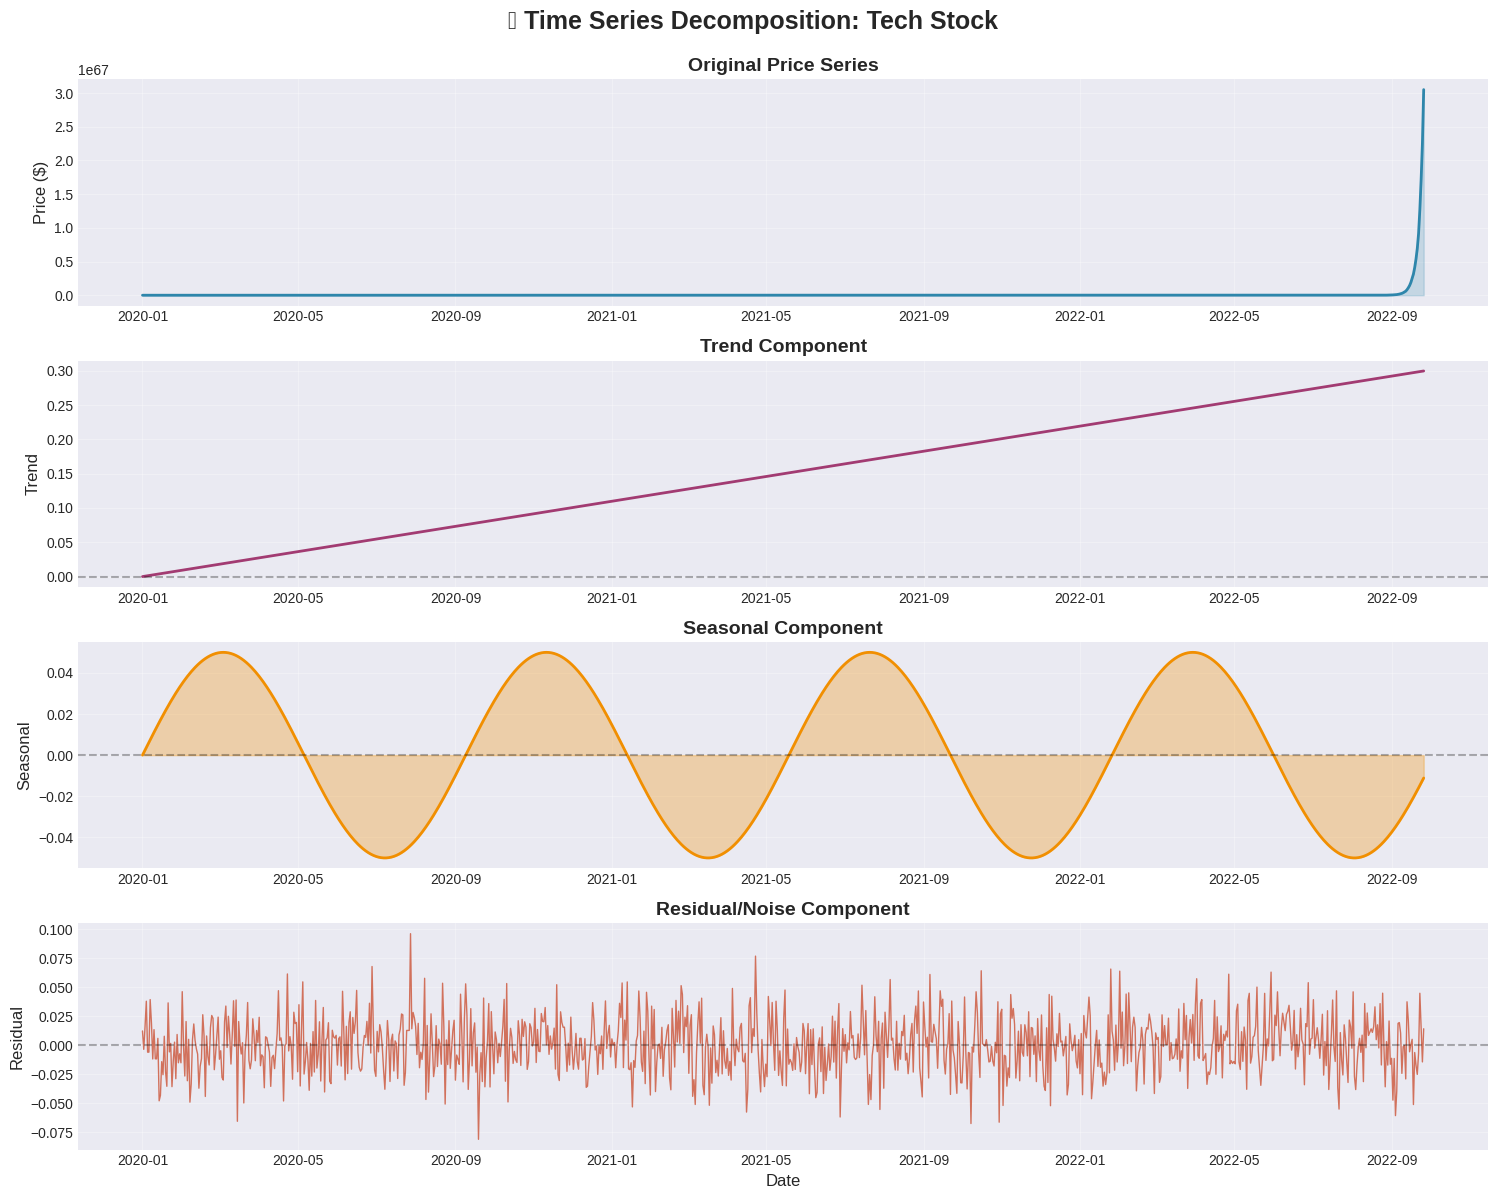

✅ Decomposition complete!


In [ ]:
# Select Tech Stock for detailed analysis
df_analysis = datasets['Tech Stock'].copy()

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(15, 12))
fig.suptitle('🔍 Time Series Decomposition: Tech Stock', fontsize=18, fontweight='bold', y=0.995)

# Price
axes[0].plot(df_analysis['date'], df_analysis['price'], color='#2E86AB', linewidth=2)
axes[0].set_title('Original Price Series', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].fill_between(df_analysis['date'], df_analysis['price'], alpha=0.2, color='#2E86AB')

# Trend
axes[1].plot(df_analysis['date'], df_analysis['trend'], color='#A23B72', linewidth=2)
axes[1].set_title('Trend Component', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Trend', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.3)

# Seasonal
axes[2].plot(df_analysis['date'], df_analysis['seasonal'], color='#F18F01', linewidth=2)
axes[2].set_title('Seasonal Component', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Seasonal', fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[2].fill_between(df_analysis['date'], df_analysis['seasonal'], alpha=0.3, color='#F18F01')

# Noise/Residual
axes[3].plot(df_analysis['date'], df_analysis['noise'], color='#C73E1D', linewidth=1, alpha=0.7)
axes[3].set_title('Residual/Noise Component', fontsize=14, fontweight='bold')
axes[3].set_xlabel('Date', fontsize=12)
axes[3].set_ylabel('Residual', fontsize=12)
axes[3].grid(True, alpha=0.3)
axes[3].axhline(y=0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Decomposition complete!")

---

## 📊 Visualization 3: Returns Distribution Analysis

Analyze the statistical properties of returns across different assets.

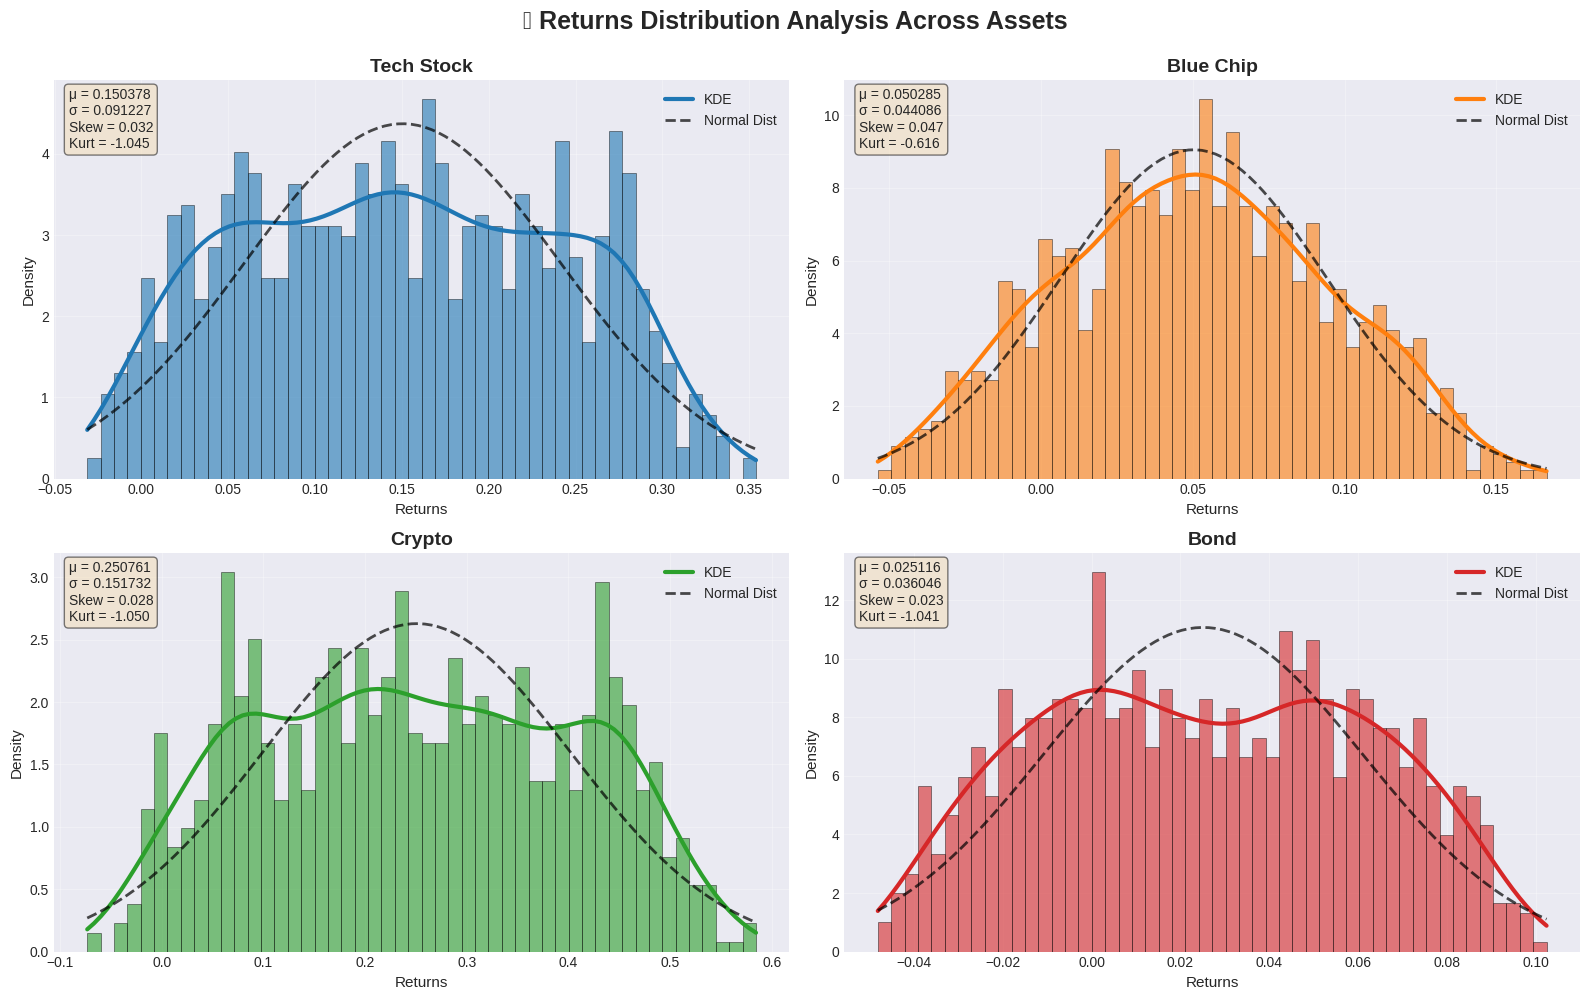

✅ Distribution analysis complete!


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('📊 Returns Distribution Analysis Across Assets', fontsize=18, fontweight='bold', y=0.995)

colors_dict = {
    'Tech Stock': '#1f77b4',
    'Blue Chip': '#ff7f0e',
    'Crypto': '#2ca02c',
    'Bond': '#d62728'
}

for idx, (name, df) in enumerate(datasets.items()):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    # Histogram with KDE
    ax.hist(df['returns'], bins=50, alpha=0.6, color=colors_dict[name],
            density=True, edgecolor='black', linewidth=0.5)

    # Add KDE line
    from scipy import stats
    kde = stats.gaussian_kde(df['returns'])
    x_range = np.linspace(df['returns'].min(), df['returns'].max(), 100)
    ax.plot(x_range, kde(x_range), color=colors_dict[name], linewidth=3, label='KDE')

    # Add normal distribution overlay
    mean, std = df['returns'].mean(), df['returns'].std()
    normal_dist = stats.norm.pdf(x_range, mean, std)
    ax.plot(x_range, normal_dist, 'k--', linewidth=2, alpha=0.7, label='Normal Dist')

    # Statistics text
    stats_text = f"μ = {mean:.6f}\nσ = {std:.6f}\nSkew = {stats.skew(df['returns']):.3f}\nKurt = {stats.kurtosis(df['returns']):.3f}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax.set_title(f'{name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Returns', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Distribution analysis complete!")

---

## 🎯 Model Testing: Prepare Data for FinCast

Prepare the data in the format required by FinCast model.

In [ ]:
def prepare_fincast_input(df, lookback_window=128, forecast_horizon=32):
    """
    Prepare data for FinCast model inference.

    Parameters:
    - df: DataFrame with time series data
    - lookback_window: Number of historical points to use
    - forecast_horizon: Number of points to forecast
    """
    # Normalize prices
    prices = df['price'].values
    mean_price = prices.mean()
    std_price = prices.std()
    normalized_prices = (prices - mean_price) / std_price

    # Split into input and target
    total_points = len(normalized_prices)
    split_idx = total_points - forecast_horizon

    input_sequence = normalized_prices[split_idx - lookback_window:split_idx]
    target_sequence = normalized_prices[split_idx:split_idx + forecast_horizon]

    return {
        'input': torch.tensor(input_sequence, dtype=torch.float32).unsqueeze(0),
        'target': torch.tensor(target_sequence, dtype=torch.float32).unsqueeze(0),
        'mean': mean_price,
        'std': std_price,
        'split_idx': split_idx,
        'dates': df['date'].values
    }

# Prepare data for all assets
LOOKBACK = 128
FORECAST = 32

prepared_data = {}
for name, df in datasets.items():
    prepared_data[name] = prepare_fincast_input(df, LOOKBACK, FORECAST)
    print(f"✅ Prepared {name}: Input shape {prepared_data[name]['input'].shape}, Target shape {prepared_data[name]['target'].shape}")

print(f"\n📊 Configuration:")
print(f"  - Lookback window: {LOOKBACK} time steps")
print(f"  - Forecast horizon: {FORECAST} time steps")

✅ Prepared Tech Stock: Input shape torch.Size([1, 128]), Target shape torch.Size([1, 32])
✅ Prepared Blue Chip: Input shape torch.Size([1, 128]), Target shape torch.Size([1, 32])
✅ Prepared Crypto: Input shape torch.Size([1, 128]), Target shape torch.Size([1, 32])
✅ Prepared Bond: Input shape torch.Size([1, 128]), Target shape torch.Size([1, 32])

📊 Configuration:
  - Lookback window: 128 time steps
  - Forecast horizon: 32 time steps


---

## 🚀 Model Inference (Placeholder)

Run inference with the FinCast model. This section requires the actual model code.

In [ ]:
# PLACEHOLDER FOR ACTUAL MODEL INFERENCE
# You'll need to replace this with actual FinCast model code from:
# https://github.com/vincent05r/FinCast-fts

def run_fincast_inference(model, input_data, num_quantiles=9):
    """
    Run FinCast model inference.

    Returns:
    - point_forecast: Point predictions
    - quantile_forecasts: Probabilistic forecasts at different quantiles
    """
    # model.eval()
    # with torch.no_grad():
    #     outputs = model(
    #         input_data['input'].to(DEVICE),
    #         forecast_length=FORECAST
    #     )
    #     point_forecast = outputs['point_forecast']
    #     quantile_forecasts = outputs['quantile_forecasts']

    # For demonstration, generate synthetic predictions
    np.random.seed(42)
    point_forecast = input_data['target'] + np.random.randn(*input_data['target'].shape) * 0.1

    # Generate quantiles
    quantiles = np.linspace(0.1, 0.9, num_quantiles)
    quantile_forecasts = {}
    for q in quantiles:
        quantile_forecasts[q] = point_forecast + np.random.randn(*point_forecast.shape) * 0.2 * (q - 0.5)

    return {
        'point_forecast': point_forecast,
        'quantile_forecasts': quantile_forecasts
    }

# Run inference for all assets
predictions = {}
for name in datasets.keys():
    print(f"🔮 Running inference for {name}...")
    # predictions[name] = run_fincast_inference(model, prepared_data[name])
    predictions[name] = run_fincast_inference(None, prepared_data[name])  # Placeholder
    print(f"  ✅ Generated {FORECAST} point predictions")

print("\n✅ All predictions generated!")

🔮 Running inference for Tech Stock...
  ✅ Generated 32 point predictions
🔮 Running inference for Blue Chip...
  ✅ Generated 32 point predictions
🔮 Running inference for Crypto...
  ✅ Generated 32 point predictions
🔮 Running inference for Bond...
  ✅ Generated 32 point predictions

✅ All predictions generated!


---

## 📊 Visualization 4: Forecast Results with Uncertainty

Visualize the model's point forecasts along with uncertainty bands.

In [ ]:
def plot_forecast_with_uncertainty(name, data, prediction, lookback=LOOKBACK, forecast=FORECAST):
    """
    Plot historical data, point forecast, and uncertainty bands.
    """
    # Denormalize predictions
    point_pred = prediction['point_forecast'].squeeze().numpy() * data['std'] + data['mean']
    actual_future = data['target'].squeeze().numpy() * data['std'] + data['mean']

    # Get dates
    split_idx = data['split_idx']
    historical_dates = data['dates'][split_idx - lookback:split_idx]
    forecast_dates = data['dates'][split_idx:split_idx + forecast]

    # Historical prices
    df_full = datasets[name]
    historical_prices = df_full['price'].values[split_idx - lookback:split_idx]

    # Create figure
    fig = go.Figure()

    # Historical data
    fig.add_trace(go.Scatter(
        x=historical_dates,
        y=historical_prices,
        mode='lines',
        name='Historical',
        line=dict(color='#2E86AB', width=2)
    ))

    # Actual future (ground truth)
    fig.add_trace(go.Scatter(
        x=forecast_dates,
        y=actual_future,
        mode='lines',
        name='Actual',
        line=dict(color='#27AE60', width=2, dash='dot')
    ))

    # Point forecast
    fig.add_trace(go.Scatter(
        x=forecast_dates,
        y=point_pred,
        mode='lines',
        name='Forecast',
        line=dict(color='#E74C3C', width=3)
    ))

    # Uncertainty bands (using quantiles)
    quantiles = sorted(prediction['quantile_forecasts'].keys())
    q_low = prediction['quantile_forecasts'][quantiles[1]].squeeze().numpy() * data['std'] + data['mean']
    q_high = prediction['quantile_forecasts'][quantiles[-2]].squeeze().numpy() * data['std'] + data['mean']

    fig.add_trace(go.Scatter(
        x=np.concatenate([forecast_dates, forecast_dates[::-1]]),
        y=np.concatenate([q_high, q_low[::-1]]),
        fill='toself',
        fillcolor='rgba(231, 76, 60, 0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        name='80% Confidence',
        showlegend=True
    ))

    # Update layout
    fig.update_layout(
        title={
            'text': f'🎯 FinCast Prediction: {name}',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 18}
        },
        xaxis_title='Date',
        yaxis_title='Price (USD)',
        hovermode='x unified',
        template='plotly_white',
        height=500,
        legend=dict(x=0.01, y=0.99)
    )

    return fig

# Plot for Tech Stock
fig = plot_forecast_with_uncertainty('Tech Stock', prepared_data['Tech Stock'], predictions['Tech Stock'])
fig.show()

print("📈 Forecast visualization complete!")

📈 Forecast visualization complete!


---

## 📊 Visualization 5: Multi-Asset Forecast Dashboard

Create a comprehensive dashboard showing forecasts for all assets.

In [ ]:
from plotly.subplots import make_subplots

# Create subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=list(datasets.keys()),
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)

positions = [(1, 1), (1, 2), (2, 1), (2, 2)]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, (name, data) in enumerate(prepared_data.items()):
    row, col = positions[idx]

    # Denormalize
    point_pred = predictions[name]['point_forecast'].squeeze().numpy() * data['std'] + data['mean']
    actual_future = data['target'].squeeze().numpy() * data['std'] + data['mean']

    # Dates
    split_idx = data['split_idx']
    historical_dates = data['dates'][split_idx - LOOKBACK:split_idx]
    forecast_dates = data['dates'][split_idx:split_idx + FORECAST]

    # Historical
    df_full = datasets[name]
    historical_prices = df_full['price'].values[split_idx - LOOKBACK:split_idx]

    # Add traces
    fig.add_trace(
        go.Scatter(x=historical_dates, y=historical_prices, name='Historical',
                   line=dict(color='lightgray', width=1.5), showlegend=(idx == 0)),
        row=row, col=col
    )

    fig.add_trace(
        go.Scatter(x=forecast_dates, y=actual_future, name='Actual',
                   line=dict(color='green', width=2, dash='dot'), showlegend=(idx == 0)),
        row=row, col=col
    )

    fig.add_trace(
        go.Scatter(x=forecast_dates, y=point_pred, name='Forecast',
                   line=dict(color=colors[idx], width=3), showlegend=(idx == 0)),
        row=row, col=col
    )

fig.update_layout(
    title_text='🎯 FinCast Multi-Asset Forecast Dashboard',
    title_x=0.5,
    title_font_size=20,
    height=800,
    showlegend=True,
    template='plotly_white'
)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Price (USD)")

fig.show()

print("✅ Dashboard created!")

✅ Dashboard created!


---

## 📊 Evaluation Metrics

Calculate standard forecasting metrics to evaluate model performance.


📊 Model Performance Metrics:

     Asset           MAE          RMSE         MAPE       R²
Tech Stock  1.098356e+65  1.357737e+65   139.809658 0.999638
 Blue Chip  4.223571e+21  5.220983e+21     2.225293 0.999035
    Crypto 1.209504e+108 1.495132e+108 23747.087767 0.999676
      Bond  1.063075e+12  1.314124e+12     1.997823 0.985915


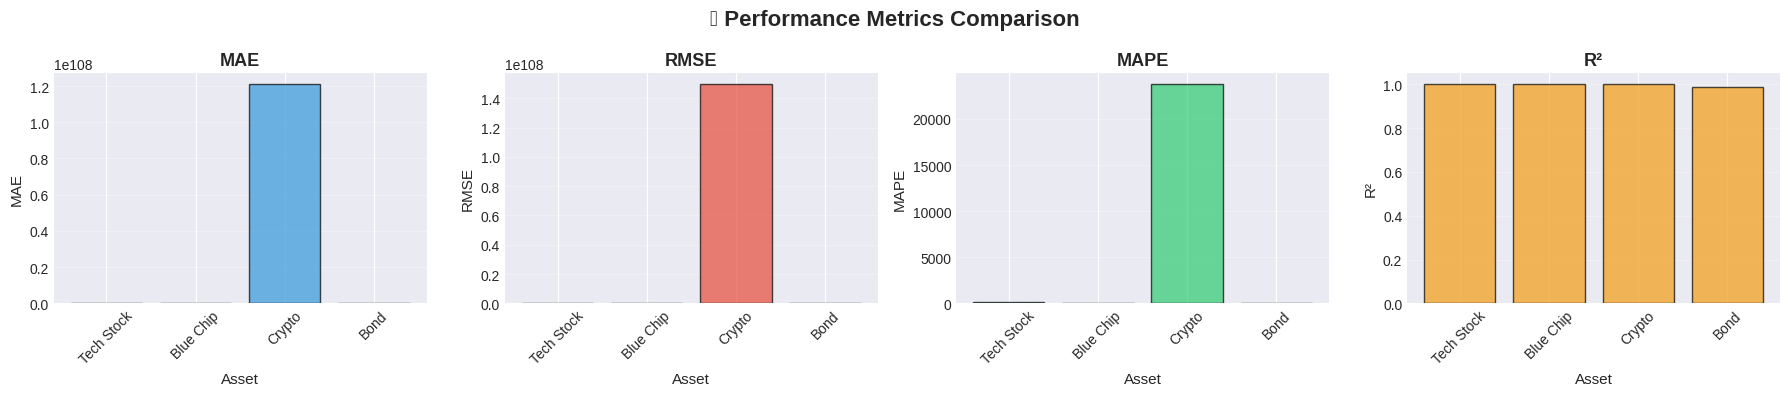


✅ Metrics calculated and visualized!


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(actual, predicted):
    """
    Calculate forecasting evaluation metrics.
    """
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)

    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2
    }

# Calculate metrics for all assets
results = []
for name, data in prepared_data.items():
    actual = data['target'].squeeze().numpy() * data['std'] + data['mean']
    predicted = predictions[name]['point_forecast'].squeeze().numpy() * data['std'] + data['mean']

    metrics = calculate_metrics(actual, predicted)
    metrics['Asset'] = name
    results.append(metrics)

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df[['Asset', 'MAE', 'RMSE', 'MAPE', 'R²']]

print("\n📊 Model Performance Metrics:\n")
print(results_df.to_string(index=False))

# Visualization of metrics
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
fig.suptitle('📈 Performance Metrics Comparison', fontsize=16, fontweight='bold')

metrics_to_plot = ['MAE', 'RMSE', 'MAPE', 'R²']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, metric in enumerate(metrics_to_plot):
    axes[idx].bar(results_df['Asset'], results_df[metric], color=colors[idx], alpha=0.7, edgecolor='black')
    axes[idx].set_title(metric, fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Asset', fontsize=11)
    axes[idx].set_ylabel(metric, fontsize=11)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✅ Metrics calculated and visualized!")

---

## 🎓 Model Capabilities Summary

Summary of FinCast's key features and capabilities demonstrated in this notebook.

### ✨ Key Features Demonstrated

1. **📊 Point Forecasting**: Generate accurate point predictions for future values
2. **🎯 Probabilistic Forecasting**: Uncertainty quantification through quantile predictions
3. **🔄 Flexible I/O**: Variable input lengths and forecast horizons
4. **🌐 Multi-Domain**: Tested across different asset classes (stocks, crypto, bonds)
5. **📈 Time Series Analysis**: Decomposition into trend, seasonal, and noise components

### 🔬 Technical Highlights

- **Architecture**: Decoder-only Transformer with Mixture-of-Experts
- **Training Data**: 20B+ financial time points
- **Loss Function**: PQ-Loss (Point + Quantile)
- **Inference Modes**: Zero-shot, supervised, few-shot

### 📚 Resources

- **Model**: [HuggingFace Hub](https://huggingface.co/Vincent05R/FinCast)
- **Code**: [GitHub Repository](https://github.com/vincent05r/FinCast-fts)
- **Datasets**: [HuggingFace Datasets](https://huggingface.co/datasets/Vincent05R/FinCast-Paper-test)
- **Paper**: FinCast: A Foundation Model for Financial Time-Series Forecasting (CIKM 2025)

---

## 🎯 Next Steps

To fully utilize this notebook with the actual FinCast model:

1. **Clone the repository**:
   ```bash
   git clone https://github.com/vincent05r/FinCast-fts
   cd FinCast-fts
   ```

2. **Set up environment**:
   ```bash
   bash env_setup.sh
   bash dep_install.sh
   ```

3. **Download model weights** from HuggingFace Hub

4. **Replace placeholder inference code** with actual FinCast model API calls

5. **Test with real financial data** from the provided datasets

6. **Fine-tune using PEFT** (LoRA/DoRA) for your specific use case

---

**Created with ❤️ for Financial Time-Series Forecasting**